In [1]:
import tensorflow as tf

class ResnetIdentityBlock(tf.keras.Model):
  def __init__(self, kernel_size, filters, batch_normalization=True, conv_first=False):
    super(ResnetIdentityBlock, self).__init__(name='')
    
    self.residual_layers = []
    
    for i in range(len(filters)):
        
        if conv_first:
            setattr(self, 'conv' + str(i+1), tf.keras.layers.Conv2D(filters[i], kernel_size, padding='same'))
            self.residual_layers.append('conv' + str(i+1))

            if batch_normalization:
                setattr(self, 'bn' + str(i+1), tf.keras.layers.BatchNormalization())
                self.residual_layers.append('bn' + str(i+1))
        
        else:
            if batch_normalization:
                setattr(self, 'bn' + str(i+1), tf.keras.layers.BatchNormalization())
                self.residual_layers.append('bn' + str(i+1))
            
            setattr(self, 'conv' + str(i+1), tf.keras.layers.Conv2D(filters[i], kernel_size, padding='same'))
            self.residual_layers.append('conv' + str(i+1))

            
            
  def call(self, input_tensor, training=False):
    
    x = input_tensor
    
    for layer in self.residual_layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            x = getattr(self, layer)(x)
        else: 
            x = getattr(self, layer)(x, training=False)
        x = tf.nn.relu(x)
        
    x += input_tensor
    return tf.nn.relu(x)

In [2]:
from keras.datasets import cifar10

(x_train,y_train),(x_test,y_test) = cifar10.load_data() 

x_train = x_train /255
x_test = x_test / 255

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


In [3]:
from keras.utils.np_utils import to_categorical   

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=5,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.05)

In [6]:
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)

NUM_EPOCHS = 80
learning_rate = 1e-4
BATCH_SIZE=128

In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=INPUT_SHAPE))

model.add(ResnetIdentityBlock((3,3), filters=(128, 128)))
model.add(ResnetIdentityBlock((3,3), filters=(128, 128)))
model.add(ResnetIdentityBlock((3,3), filters=(128, 128)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))

model.add(ResnetIdentityBlock((3,3), filters=(64, 64)))
model.add(ResnetIdentityBlock((3,3), filters=(64, 64)))
model.add(ResnetIdentityBlock((3,3), filters=(64, 64)))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.AveragePooling2D(pool_size=8))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))

In [8]:
model.summary()

datagen.fit(x_train)

sgd = tf.keras.optimizers.Adam(learning_rate)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(x_test, y_test),
                    epochs=NUM_EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 128)       3584      
_________________________________________________________________
resnet_identity_block (Resne (None, 30, 30, 128)       296192    
_________________________________________________________________
resnet_identity_block_1 (Res (None, 30, 30, 128)       296192    
_________________________________________________________________
resnet_identity_block_2 (Res (None, 30, 30, 128)       296192    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 64)        73792     
_________________________________________________________________
resnet_identity_block_3 (Res (None, 30, 30, 64)        74368     
_________________________________________________________________
resnet_identity_block_4 (Res (None, 30, 30, 64)        7

391/391 [==============================] - 44s 112ms/step - loss: 0.3285 - accuracy: 0.8875 - val_loss: 0.7401 - val_accuracy: 0.7809
Epoch 43/80
391/391 [==============================] - 44s 114ms/step - loss: 0.3229 - accuracy: 0.8892 - val_loss: 0.5485 - val_accuracy: 0.8250
Epoch 44/80
391/391 [==============================] - 44s 112ms/step - loss: 0.3146 - accuracy: 0.8917 - val_loss: 0.4624 - val_accuracy: 0.8482
Epoch 45/80
391/391 [==============================] - 43s 111ms/step - loss: 0.3101 - accuracy: 0.8928 - val_loss: 0.6629 - val_accuracy: 0.7995
Epoch 46/80
391/391 [==============================] - 43s 111ms/step - loss: 0.3015 - accuracy: 0.8973 - val_loss: 0.5601 - val_accuracy: 0.8238
Epoch 47/80
391/391 [==============================] - 43s 110ms/step - loss: 0.2954 - accuracy: 0.8979 - val_loss: 0.8490 - val_accuracy: 0.7772
Epoch 48/80
391/391 [==============================] - 43s 110ms/step - loss: 0.2883 - accuracy: 0.9013 - val_loss: 0.5196 - val_accurac

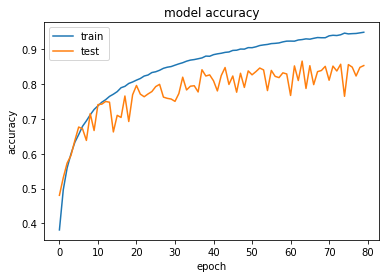

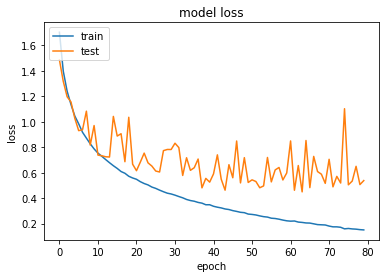

In [9]:
history1 = model.history.history

# summarize history for accuracy
plt.plot(history1['accuracy'])
plt.plot(history1['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
mode = tf.keras.Sequential()
mode.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=INPUT_SHAPE))

mode.add(ResnetIdentityBlock((3,3), filters=(256, 256)))
mode.add(ResnetIdentityBlock((3,3), filters=(256, 256)))
mode.add(ResnetIdentityBlock((3,3), filters=(256, 256)))
mode.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))


mode.add(ResnetIdentityBlock((3,3), filters=(128, 128)))
mode.add(ResnetIdentityBlock((3,3), filters=(128, 128)))
mode.add(ResnetIdentityBlock((3,3), filters=(128, 128)))
mode.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))

mode.add(ResnetIdentityBlock((3,3), filters=(64, 64)))
mode.add(ResnetIdentityBlock((3,3), filters=(64, 64)))
mode.add(ResnetIdentityBlock((3,3), filters=(64, 64)))

mode.add(tf.keras.layers.BatchNormalization())
mode.add(tf.keras.layers.Activation('relu'))
mode.add(tf.keras.layers.AveragePooling2D(pool_size=8))
mode.add(tf.keras.layers.Flatten())

mode.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))

In [11]:
mode.summary()

datagen.fit(x_train)

sgd = tf.keras.optimizers.Adam(learning_rate)

mode.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

mode.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(x_test, y_test),
                    epochs=NUM_EPOCHS)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 30, 30, 256)       7168      
_________________________________________________________________
resnet_identity_block_6 (Res (None, 30, 30, 256)       1182208   
_________________________________________________________________
resnet_identity_block_7 (Res (None, 30, 30, 256)       1182208   
_________________________________________________________________
resnet_identity_block_8 (Res (None, 30, 30, 256)       1182208   
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 30, 30, 128)       295040    
_________________________________________________________________
resnet_identity_block_9 (Res (None, 30, 30, 128)       296192    
_________________________________________________________________
resnet_identity_block_10 (Re (None, 30, 30, 128)      

Epoch 39/80
391/391 [==============================] - 112s 287ms/step - loss: 0.1608 - accuracy: 0.9455 - val_loss: 0.8299 - val_accuracy: 0.7842
Epoch 40/80
391/391 [==============================] - 112s 287ms/step - loss: 0.1567 - accuracy: 0.9464 - val_loss: 0.6573 - val_accuracy: 0.8302
Epoch 41/80
391/391 [==============================] - 112s 287ms/step - loss: 0.1493 - accuracy: 0.9498 - val_loss: 0.4450 - val_accuracy: 0.8645
Epoch 42/80
391/391 [==============================] - 113s 288ms/step - loss: 0.1458 - accuracy: 0.9504 - val_loss: 0.4873 - val_accuracy: 0.8625
Epoch 43/80
391/391 [==============================] - 112s 287ms/step - loss: 0.1424 - accuracy: 0.9515 - val_loss: 0.4631 - val_accuracy: 0.8679
Epoch 44/80
391/391 [==============================] - 112s 287ms/step - loss: 0.1309 - accuracy: 0.9551 - val_loss: 0.4896 - val_accuracy: 0.8609
Epoch 45/80
391/391 [==============================] - 112s 287ms/step - loss: 0.1254 - accuracy: 0.9571 - val_loss: 0

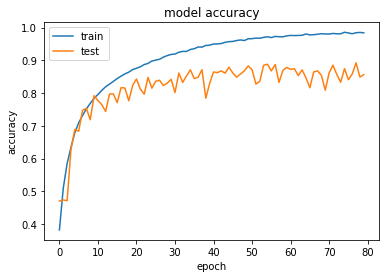

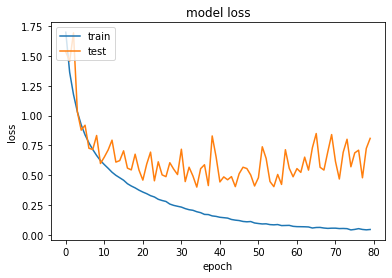

In [12]:
history = mode.history.history

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#VGG16 MODEL

In [14]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

vgg16_model = VGG16(weights='imagenet',
                    include_top=False, 
                    classes=10,
                    input_shape=(32,32,3)# input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

58892288/58889256 [==============================] - 1s 0us/step


In [15]:
model1 = Sequential()
for layer in vgg16_model.layers:
    model1.add(layer)


In [16]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
model1.add(Flatten())
model1.add(Dense(512, activation='relu', name='hidden1'))
model1.add(Dropout(0.4))
model1.add(Dense(256, activation='relu', name='hidden2'))
model1.add(Dropout(0.4))
model1.add(Dense(10, activation='softmax', name='predictions'))

model1.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

In [18]:
sgd = optimizers.SGD(lr=0.001, momentum=0.9)

# For a multi-class classification problem
model1.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])


es = EarlyStopping(patience=10, monitor='val_accuracy', mode='max')

# initialize the number of epochs and batch size
EPOCHS = 100
BS = 32

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                        horizontal_flip=True, fill_mode="nearest")
 
# train the model
history = model1.fit_generator(aug.flow(x_train,y_train, batch_size=BS),validation_data=(x_test,y_test), 
                              steps_per_epoch=len(x_train) // BS ,epochs=EPOCHS ,callbacks=[es])


Train for 1562 steps, validate on 10000 samples
Epoch 1/100
1562/1562 [==============================] - 48s 31ms/step - loss: 1.3475 - accuracy: 0.5265 - val_loss: 0.8084 - val_accuracy: 0.7215
Epoch 2/100
1562/1562 [==============================] - 47s 30ms/step - loss: 0.8997 - accuracy: 0.6991 - val_loss: 0.6155 - val_accuracy: 0.7882
Epoch 3/100
1562/1562 [==============================] - 48s 30ms/step - loss: 0.7566 - accuracy: 0.7488 - val_loss: 0.5864 - val_accuracy: 0.8023
Epoch 4/100
1562/1562 [==============================] - 47s 30ms/step - loss: 0.6764 - accuracy: 0.7759 - val_loss: 0.5625 - val_accuracy: 0.8133
Epoch 5/100
1562/1562 [==============================] - 46s 29ms/step - loss: 0.6243 - accuracy: 0.7932 - val_loss: 0.5120 - val_accuracy: 0.8270
Epoch 6/100
1562/1562 [==============================] - 45s 29ms/step - loss: 0.5807 - accuracy: 0.8072 - val_loss: 0.4603 - val_accuracy: 0.8444
Epoch 7/100
1562/1562 [==============================] - 46s 30ms/step

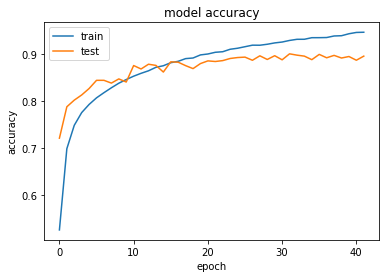

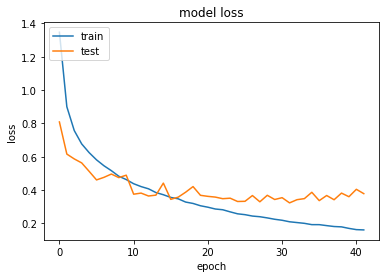

In [19]:


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()